In [1]:
time_start = dt.now()

### Functions

In [2]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
    }

### 1. Prepare dataset

In [3]:
# read train dataset
df1 = pd.read_csv('data/train.csv')
df1['row_id'] = range(len(df1))

# read test dataset
df2 = pd.read_csv('data/new/test.csv')
df2['row_id'] = range(len(df2))
df2['row_id'] = df2['row_id']  + 1000000

# merge
df = pd.concat([df1,df2])
del df1,df2
gc.collect()

# add fold for splitting
np.random.seed(1234)
df['fold'] = np.random.randint(0,3,len(df))
# drop some features
feats_drop = ['timestamp','active_power_calculated_by_converter','reactice_power_calculated_by_converter']
for f in feats_drop:
    if f in df.columns:
        del df[f]
# label encoder of categorical feats
feats_cat = ['turbine_id']
list_lbl  = []
for f in feats_cat:
    lbl = preprocessing.LabelEncoder()
    df[f] = lbl.fit_transform(df[f])
    list_lbl.append(lbl)

In [4]:
for i,l in enumerate(lbl.classes_):
    print(i, l)

0 Turbine_01
1 Turbine_10
2 Turbine_103
3 Turbine_105
4 Turbine_108
5 Turbine_120
6 Turbine_123
7 Turbine_13
8 Turbine_139
9 Turbine_14
10 Turbine_15
11 Turbine_158
12 Turbine_18
13 Turbine_19
14 Turbine_20
15 Turbine_97


In [5]:
feats_used = [    
    "turbine_id",
    
    "active_power_raw",
    "ambient_temperature",
    "generator_speed",
    "generator_winding_temp_max",
    "grid_power10min_average",
    "nc1_inside_temp",
    "nacelle_temp",
    "reactive_power",
    "wind_direction_raw",
    "wind_speed_raw",
    "wind_speed_turbulence",
  
]

### 2. Training

In [6]:
# Sets creation
feat_target = 'Target'

filt_fold  = df.fold == 0
filt_null  = df[feat_target].isnull()

filt_train = ~filt_fold & ~filt_null
filt_valid = filt_fold & ~filt_null
filt_test  = filt_null

x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]
xt, yt = df[filt_test][feats_used],  df[filt_test][feat_target]

print(x.shape, xv.shape, xt.shape)

del df
gc.collect()
x[:3]

(606820, 12) (302784, 12) (303202, 12)


,turbine_id,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,4,834.92,31.69,"1,159.62",65.95,917.90,31.88,31.50,165.50,280.86,7.06,0.54
1,12,421.05,12.89,928.75,59.57,445.55,32.42,32.76,113.84,299.55,5.47,0.47
5,10,620.64,28.06,955.60,60.88,697.72,31.01,31.05,75.78,229.57,6.03,0.78


In [7]:
# Training process
import xgboost as xgb
x_ = xgb.DMatrix(x.values, 
                label = y, 
                feature_names = feats_used)
xv_ = xgb.DMatrix(xv.values, 
                label = yv, 
                feature_names = feats_used) 
xt_ = xgb.DMatrix(xt.values, 
                label = yt, 
                feature_names = feats_used)

In [8]:
params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'reg:squarederror', 
        # 'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 6,  # -1 means no limit
        'subsample': 1,  # Subsample ratio of the training instance.
        'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree.
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': -1,
        'verbosity': 0
    }       

# del x, xv, xt
# gc.collect()

early_stopping_rounds = 50
num_boost_round       = 20000

evals_results = dict()
model_xgb = xgb.train(params, 
             x_, 
             evals=[
                 (x_,'train'), 
                 (xv_,'valid'),
                 # (xt_,'test'),
             ], 
             evals_result=evals_results, 
             num_boost_round=num_boost_round,
             early_stopping_rounds=early_stopping_rounds,
             verbose_eval=1000)

[0]	train-rmse:41.32114	valid-rmse:41.31805
[1000]	train-rmse:1.11777	valid-rmse:1.20559
[2000]	train-rmse:0.99535	valid-rmse:1.13927
[3000]	train-rmse:0.92113	valid-rmse:1.11217
[4000]	train-rmse:0.86526	valid-rmse:1.09519
[5000]	train-rmse:0.82121	valid-rmse:1.08669
[6000]	train-rmse:0.78237	valid-rmse:1.07884
[7000]	train-rmse:0.74889	valid-rmse:1.07360
[8000]	train-rmse:0.71831	valid-rmse:1.06896
[9000]	train-rmse:0.68887	valid-rmse:1.06474
[10000]	train-rmse:0.66317	valid-rmse:1.06256
[11000]	train-rmse:0.64008	valid-rmse:1.06020
[12000]	train-rmse:0.61719	valid-rmse:1.05856
[12371]	train-rmse:0.60900	valid-rmse:1.05799


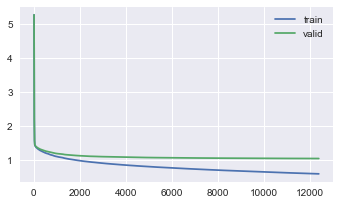

In [9]:
plt.style.use('seaborn')
df_evals = pd.DataFrame({
            'train': evals_results['train']['rmse'],
            'valid': evals_results['valid']['rmse'],
            # 'test': evals_results['test']['rmse'],
})
_ = df_evals[20:].plot(figsize = (5,3))

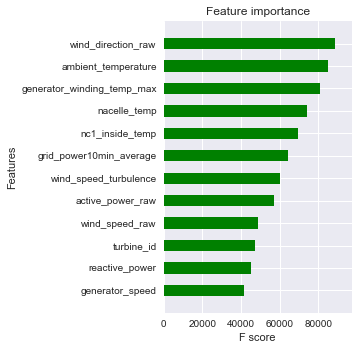

In [18]:
_, ax = plt.subplots(1,1, figsize = (3,5))
_ = xgb.plot_importance(model_xgb, ax = ax, max_num_features=30, height=0.5, 
                        show_values=False, color = 'green')

In [11]:
pred = model_xgb.predict(xv_)
ts_metrics(yv, pred)

{'mae': 0.7189640998091219,
 'mse': 1.1193573641761427,
 'mape': 0.015451574931622653,
 'smape': 0.015411941934114328}

In [12]:
# predictions
df_out = pd.DataFrame({
    'Target': pred
})
df_out.to_csv('output/valid_xgb.csv', index = False, sep = ',')

df_out = pd.DataFrame({
    'Target': model_xgb.predict(xt_)
})
df_out.to_csv('output/main_xgb.csv', index = False, sep = ',')

In [13]:
print('Working time: ', dt.now() - time_start) 

Working time:  0:07:09.899360
